In [16]:
using Pkg;

In [16]:
Pkg.add("DataFrames");
Pkg.add("CSV");
Pkg.add("Lazy");
Pkg.add("VegaLite");

In [3]:
using DataFrames;
using Lazy: @>, @>>, @as
using VegaLite
import CSV;

In [6]:
using Dates: DateTime, datetime2unix

In [214]:
proposals_df = begin
    proposals_input_path = "bisq-proposals.csv"
    @> proposals_input_path CSV.File DataFrame
end;

cycles_df = begin
    cycles_input_path = "bisq-cycles.csv"
    @> cycles_input_path CSV.File DataFrame
end;

In [284]:
# "results/dao-results-daily.csv" is obtained by running m52go's script on BSQ burn txs dump.

daily_burn_df = begin
    daily_burn_input_path = "results/dao-results-daily.csv"
    @> daily_burn_input_path CSV.File DataFrame
    end;

In [285]:
yearmonthday2dt_repr(ymd) = @>> DateTime(string(ymd), "yyyymmdd") repr

daily_burn_df = begin
    col_to_dt_repr = col -> map(yearmonthday2dt_repr, col)
    ymd_and_dateTime = @> daily_burn_df by(:yearmonthday, dateTime = :yearmonthday => col_to_dt_repr)
    join(daily_burn_df, ymd_and_dateTime, on = :yearmonthday)
end;

In [286]:
# Match burn events to cycle indexes by comparing burn timestamp and cycle starting time.
# A burn event is matched with a cycle if it happens during that cycle.

cycle_datetimes = @>> cycles_df.startTime map(x -> x / 1000) map(unix2datetime)

match_dt_to_cycle(cycle_datetimes, dt) = begin
    cycle_i = 0;
    for cycle_dt in cycle_datetimes
        cycle_i = cycle_i + 1;
        before = dt < cycle_dt
        if before
            return cycle_i - 1
            # if a given burn event happened before the first provided cycle startTime, it will have cycleIndex 0
        end
    end
    return cycle_i
end

match_dt_to_cycle(dt_repr) = @>> dt_repr DateTime match_dt_to_cycle(cycle_datetimes)

daily_burn_df = begin
    dateTime_and_cycleIndex = @> daily_burn_df by(:dateTime, cycleIndex = :dateTime => col -> map(match_dt_to_cycle, col))
    join(daily_burn_df, dateTime_and_cycleIndex, on = :dateTime)
end;

In [287]:
# discard burns happening before first provided cycle
daily_burn_df = daily_burn_df[daily_burn_df.cycleIndex .!= 0, :];

In [288]:
get_rid_of_dashes(s) = replace(s, "-" => "_")
get_rid_of_symbol_dashes(sy) = @> sy string get_rid_of_dashes
rename!(get_rid_of_symbol_dashes, daily_burn_df);

In [289]:
mysterious_multiplier = 100
summed_burn = @> daily_burn_df by(:cycleIndex, summed_burn = :total_fees => x -> sum(x * mysterious_multiplier) )
summed_issue = @> proposals_df by(:cycleIndex, summed_issue = :proposal_requestedBsq => x -> @> x skipmissing sum)
burn_and_issue_per_cycle = join(summed_burn, summed_issue, on = :cycleIndex);

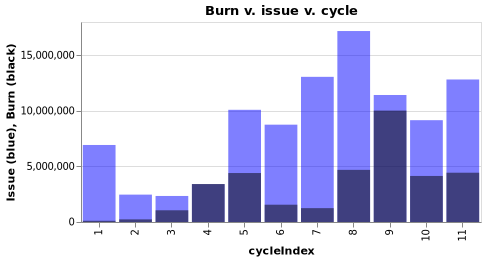

In [290]:
burn_and_issue_per_cycle |>
@vlplot(
    title="Burn v. issue v. cycle",
    x="cycleIndex:o",
    width=400,
) + @vlplot(
    mark={:bar, color=:blue, opacity=0.5},
    y={"summed_issue", title="Issue (blue)"},
) + @vlplot(
    mark={:bar, color=:black, opacity=0.5},
    y={"summed_burn", title="Burn (black)"},
)

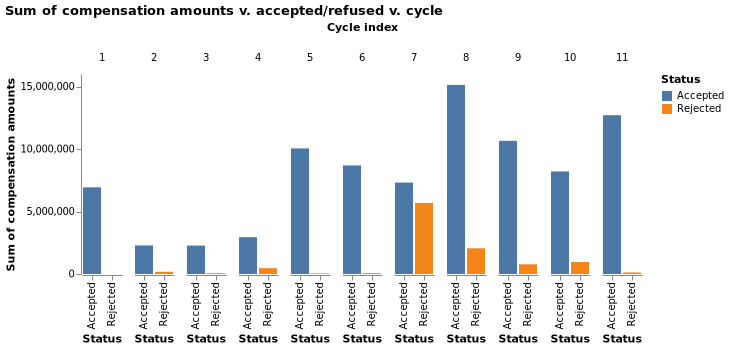

In [291]:
proposals_df |>
@vlplot(
    mark=:bar,
    title="Sum of compensation amounts v. accepted/refused v. cycle",
    transform=[
        {filter="datum.proposal_txType == 'COMPENSATION_REQUEST'"}
    ],
    encoding={
        y={
            "sum(proposal_requestedBsq):q",
            axis={grid=false},
            title="Sum of compensation amounts"
        },
        x={
            "isAccepted:n",
            title="Status"
        },
        column={
            "cycleIndex:o",
            title="Cycle index"
        },
        color={
            "isAccepted:n",
            title="Status"
        }
    },
    spacing=10,
    config={
        view={stroke=:transparent},
        axis={domainWidth=1}
    }
)

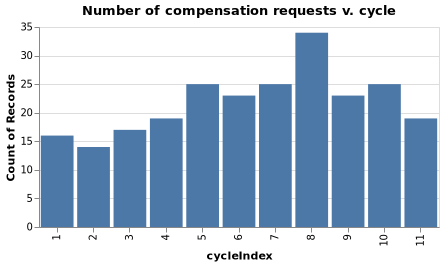

In [292]:
proposals_df |>
@vlplot(
    title="Number of compensation requests v. cycle",
    transform=[
        {filter="datum.proposal_txType == 'COMPENSATION_REQUEST'"}
    ],
    width=400,
    mark=:bar,
    x="cycleIndex:o",
    y="count()",
)

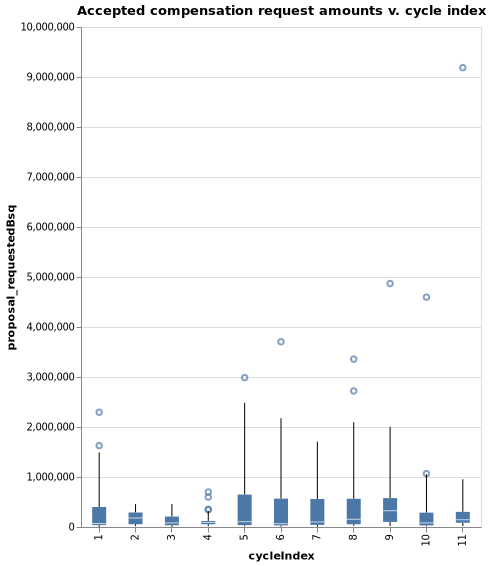

In [293]:
proposals_df |>
@vlplot(
    title="Accepted compensation request amounts v. cycle index",
    transform=[
        {filter="datum.proposal_txType == 'COMPENSATION_REQUEST'"},
        {filter="datum.isAccepted == 'Accepted'"},
    ],
    width=400,
    height=500,
    mark={:boxplot, extent="3.0"},
    x="cycleIndex:o",
    y={"proposal_requestedBsq", scale={type=:linear}},
)

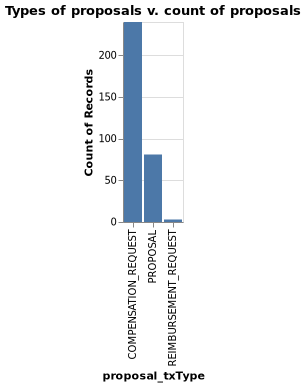

In [294]:
proposals_df |>
@vlplot(
    title="Types of proposals v. count of proposals",
    mark=:bar,
    encoding={
        y="count()",
        x="proposal_txType:n"
    }
)

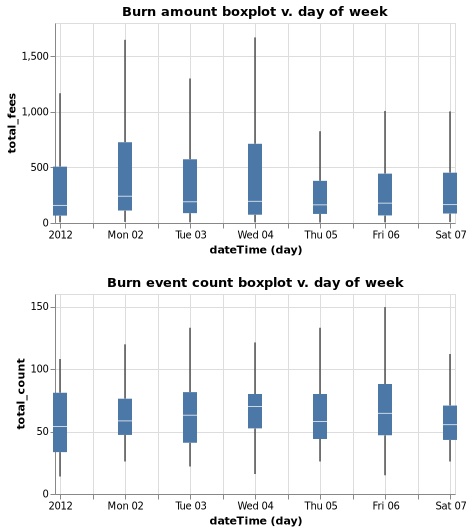

In [299]:
daily_burn_df |>
@vlplot() + [
@vlplot(
    title="Burn amount boxplot v. day of week",
    width=400,
    mark={:boxplot, extent="1.5"},
    encoding={
        x={timeUnit=:day, field=:dateTime, type=:temporal},
        y=:total_fees,
    }
); @vlplot(
    title="Burn event count boxplot v. day of week",
    mark={:boxplot, extent="1.5"},
    width=400,
    x={timeUnit=:day, field=:dateTime, type=:temporal},
    y="total_count"
    )
]